In [43]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

### Get data

In [7]:
DATA_PATH = os.path.abspath(os.path.join('..', '..', '..', 'data', 'processed', 'ravdess'))

In [8]:
def load_data(data_path):
    all_data = []
    all_labels = []

    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            data = np.load(os.path.join(data_path, file), allow_pickle=True)
            data = np.array(data, dtype=np.float32)

            all_data.append(data)

            label = int(file.split("-")[2])
            all_labels.append(label)

    return np.array(all_data, dtype=object), np.array(all_labels)

In [4]:
all_data, all_labels = load_data(DATA_PATH)

In [5]:
def preprocess_data(data, labels):
    tensor_data = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_data = pad_sequence(tensor_data, batch_first=True)

    encoder = LabelBinarizer()
    encoded_labels = encoder.fit_transform(labels)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)

    X_train, X_temp, y_train, y_temp = train_test_split(
        padded_data, encoded_labels, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

# PODEJŚCIE 1 - Dodanie warstwy self-attention

## MODEL

Próba dodania warstwy atencji, by model automatycznie decydował które z landmarków są ważne.

In [9]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_landmarks=478):
        super(EmotionClassifier, self).__init__()
        
        self.num_landmarks = num_landmarks
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Attention layer: Assign weights to each landmark
        self.attention = nn.Linear(num_landmarks // 2, num_landmarks // 2)  # Reduce dimensionality
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=(num_landmarks // 2) * 32, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128 * 2, hidden_size=64, batch_first=True)
        
        # Fully connected classification layer
        self.fc = nn.Linear(64, 8)

    def forward(self, x):
        batch_size, frames, landmarks, coordinates = x.shape
        x = x.view(-1, landmarks, coordinates).permute(0, 2, 1)  # Shape: (batch_size*frames, 2, 478)
        
        x = F.relu(self.conv1(x))  # Shape: (batch_size*frames, 32, 478)
        x = self.pool1(x)  # Shape: (batch_size*frames, 32, 239) - Because of pooling
        
        # Compute landmark importance using attention
        x_mean = x.mean(dim=1)  # Average over filters -> (batch_size*frames, 239)
        attn_weights = torch.sigmoid(self.attention(x_mean))  # Learnable landmark weights
        
        x = x * attn_weights.unsqueeze(1)  # Apply learned importance to landmarks
        
        x = x.view(batch_size, frames, -1)  
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        x = self.fc(x[:, -1, :])  
        return x


## Trening

In [10]:
BATCH_SIZE = 32
EPOCHS = 10
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [12]:
writer = SummaryWriter("runs/torch-lstm/feature_selection")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.argmax(dim=1)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)
    
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.argmax(dim=1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(y_batch).sum().item()
            total += y_batch.size(0)
    
    val_acc = correct / total

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10, Train Loss: 130.3980, Train Acc: 0.1123, Val Loss: 28.9164, Val Acc: 0.1276
Epoch 2/10, Train Loss: 130.1928, Train Acc: 0.1262, Val Loss: 28.8770, Val Acc: 0.1276
Epoch 3/10, Train Loss: 130.0470, Train Acc: 0.1292, Val Loss: 28.8632, Val Acc: 0.1253
Epoch 4/10, Train Loss: 130.0772, Train Acc: 0.1163, Val Loss: 28.8634, Val Acc: 0.1369
Epoch 5/10, Train Loss: 130.0665, Train Acc: 0.1248, Val Loss: 28.8711, Val Acc: 0.1276
Epoch 6/10, Train Loss: 130.0158, Train Acc: 0.1292, Val Loss: 28.8616, Val Acc: 0.1276
Epoch 7/10, Train Loss: 130.0642, Train Acc: 0.1262, Val Loss: 28.8668, Val Acc: 0.1276
Epoch 8/10, Train Loss: 130.0577, Train Acc: 0.1302, Val Loss: 28.8534, Val Acc: 0.1462
Epoch 9/10, Train Loss: 130.0625, Train Acc: 0.1397, Val Loss: 28.8581, Val Acc: 0.1276
Epoch 10/10, Train Loss: 129.9969, Train Acc: 0.1233, Val Loss: 28.8658, Val Acc: 0.1369


## SHAP wartości

In [21]:
batch_size = 10
num_samples = 100
shap_values_all = []

model.eval()
explainer = shap.DeepExplainer(model, X_train[:5].to(device))
"""
== Lundberg et al. (2017) – "A Unified Approach to Interpreting Model Predictions" ==

Experiment: Compared different reference set sizes and found that after 1-3 samples, the marginal gain in accuracy was minimal.
Key Finding: Using more reference samples does not significantly change the rankings of important features.
"""

model.train() # because of RNN backprop error
for i in tqdm(range(0, num_samples, batch_size), total=num_samples / batch_size):
    batch = X_train[i : i + batch_size].to(device)
    shap_values_batch = explainer.shap_values(batch, check_additivity=False)
    shap_values_all.append(shap_values_batch)

shap_values_all = np.concatenate(shap_values_all, axis=0)


  0%|          | 0/10.0 [00:00<?, ?it/s]C:\Users\Bartosz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning:

unrecognized nn.Module: LSTM

100%|██████████| 10/10.0 [00:11<00:00,  1.13s/it]


In [22]:
shap_landmark_importance_per_frame = torch.tensor(shap_values_all).abs().sum(dim=3)
shap_landmark_importance = shap_landmark_importance_per_frame.abs().sum(dim=1)
shap_landmark_importance_avg = shap_landmark_importance.abs().mean(dim=-1).mean(dim=0)

In [26]:
shap_landmark_importance_avg.shape

torch.Size([478])

C:\Users\Bartosz\AppData\Local\Temp\ipykernel_16248\1715303189.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




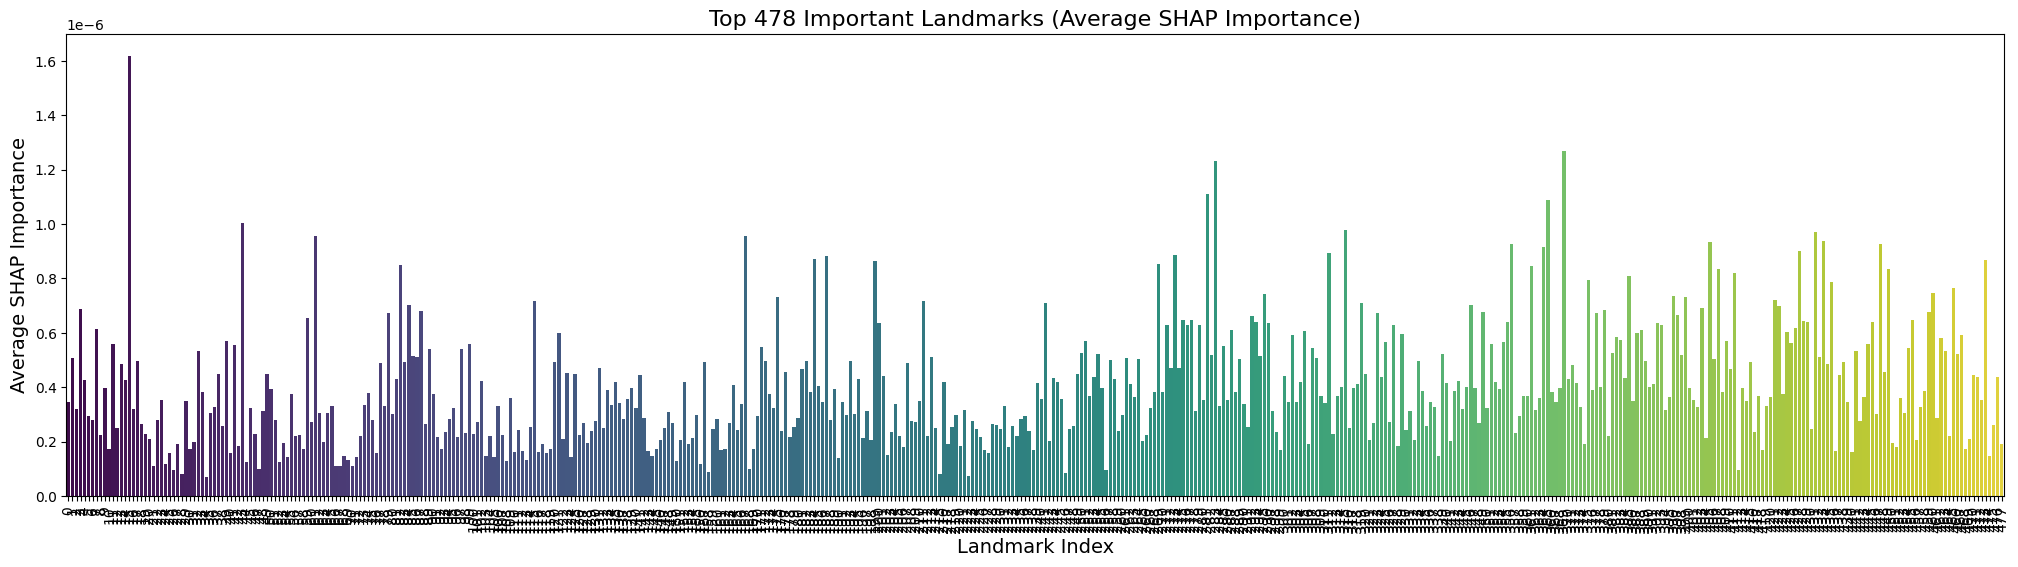

In [28]:
sorted_indices = torch.argsort(-shap_landmark_importance_avg)

sorted_importance = shap_landmark_importance_avg[sorted_indices]
sorted_landmarks = sorted_indices.tolist()

top_k = 478  # Number of top landmarks to show
df = pd.DataFrame({
    'Landmark Index': sorted_landmarks[:top_k],
    'Average SHAP Importance': sorted_importance[:top_k].numpy()
})

plt.figure(figsize=(25, 6))
sns.barplot(x='Landmark Index', y='Average SHAP Importance', data=df, palette='viridis')
plt.title(f'Top {top_k} Important Landmarks (Average SHAP Importance)', fontsize=16)
plt.xlabel('Landmark Index', fontsize=14)
plt.ylabel('Average SHAP Importance', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [60]:
reference_landmarks = np.load(os.path.join('..', '..', '..', 'data', 'reference_points', 'key_points_xyz.npy'))[0, :, :2]
number_landmarks = reference_landmarks.shape[0]

fig = go.Figure()

frames = []
for t in range(1, number_landmarks):
    landmarks_plot = go.Scatter(
        x=[p[0] for p in reference_landmarks[[sorted_landmarks[:t]]][0]],
        y=[1 - p[1] for p in reference_landmarks[[sorted_landmarks[:t]]][0]],
        mode='markers',
        marker=dict(
            size=10,
            color='red',
            opacity=1
        )
    )

    frames.append(go.Frame(
        data=[landmarks_plot],
        name=str(t)
    ))

fig.frames = frames

fig.add_trace(go.Scatter(
    x=[p[0] for p in reference_landmarks[:1]],
    y=[1 - p[1] for p in reference_landmarks[:1]],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=1
    )
))

fig.update_layout(
    height=800,
    width=800,
    title="Most Important Landmarks",
    xaxis=dict(range=[0, 1], title="X coord"),
    yaxis=dict(range=[0, 1], title="Y coord"),
    sliders=[{
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "no. landmarks",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [{
            "args": [
                [f.name],
                {
                    "frame": {"duration": 300, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 300}
                }
            ],
            "label": f.name,
            "method": "animate"
        } for f in frames]
    }]
)

fig.show()

# PODEJŚCIE 2 - Trening autoencodera.

- Train a 1D convolutional autoencoder with your raw time-series data.
- Extract the most informative latent features instead of all landmarks.
- Use only these features in your final classifier.